# Planification de la trajectoire d'un objet mobile à partir des images video
### BRIKCI Mohammed El Hadi et BRAHIM Riadh

Dans ce code on a une solution pour detection les marquage des lignes de la voie . En suivant les etapes suivante:

1. Calibration de la Camera   
2. Correction de Distortion    
3. Seuillage de Gradient (Canny) et Seuillage de couleur 
4. Transformation de Perspective    
5. La recherche des lignes de la voie (Sliding windows) & Optimization de la recherche (merging search)
6. Dessiner de la superposition de voie
7. Calcule le rayon de la courbure et le décalage de la voiture

##### Les Bibliothèques requises

In [3]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import io
import os
import glob
%matplotlib inline

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


## 1. Calculer l'étalonnage de la caméra à l'aide d'images d'échiquier

In [4]:
images = glob.glob('camera_cal/calibration*.jpg') #glob pour charger +ieurs images

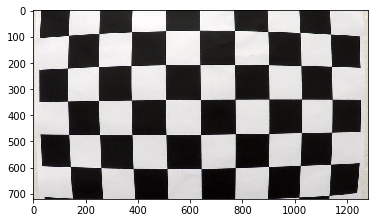

In [5]:
img = mpimg.imread(images[0]) #Liire la 1er image
plt.imshow(img);

In [6]:
# stocker les coordonnées de l'échiquier 
chess_points = []
# stocker les points img transformés
image_points = []

In [7]:
# Spécifier le nombre de Lignes et columnes a 6, 9. chaque élément est en (xyz) point 
# Rappel, on s'interesse que des points intérieurs. c'est pour sa la plache d'échiquier est de 9x6, au lieu 10x7
chess_point = np.zeros((9*6, 3), np.float32)
# z reste zero. définir xy au valeurs de la grille
chess_point[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [8]:
for image in images:
    # Lire les images d'echiquier
    img = mpimg.imread(image) 
    # convertir au niveau de gris
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    
    # returner booléen s/e et les coordonnes
    success, corners = cv.findChessboardCorners(gray, (9,6), None)
    
    if success:
        image_points.append(corners)
        # Ils seront tous les mêmes puisque c'est la même planche
        chess_points.append(chess_point)
    else:
        print('corners not found {}'.format(image))
        

corners not found camera_cal\calibration1.jpg
corners not found camera_cal\calibration4.jpg
corners not found camera_cal\calibration5.jpg


<Figure size 432x288 with 0 Axes>

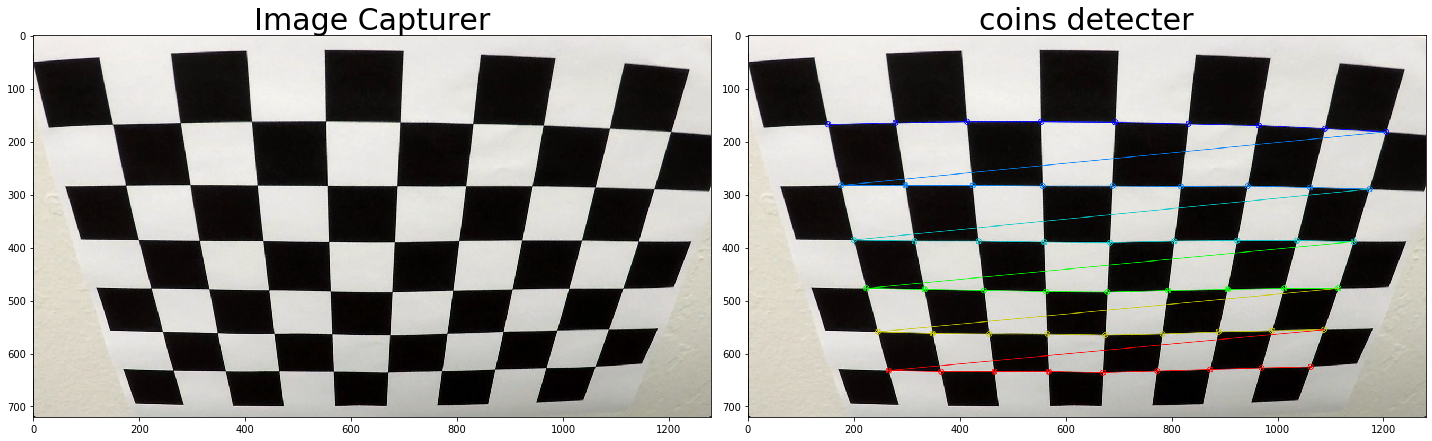

In [10]:
# Puisque les images 1,4,5 ne sont pas chargé ont va lire la 2eme
image = mpimg.imread('./camera_cal/calibration2.jpg')
# affichage des résultats 
plt.figure();
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(image);
ax1.set_title('Image Capturer', fontsize=30);

gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY) 
ret , corners = cv.findChessboardCorners(gray,(9,6),None)    
if ret == False:
    print('coins non detecter')
img1 = cv.drawChessboardCorners(image,(9,6),corners,ret) 

ax2.imshow(img1);
ax2.set_title('coins detecter', fontsize=30);
plt.tight_layout();
plt.savefig('saved_figures/chess_corners.png'); # vous devez creer un dossier pour sauvgarder les figures
plt.show;

In [11]:
# Sauvegarder les donnees dans un fichier Pickle! et je l'ai mis en comentaire pcq c'est pas la peine de sauvegarder a chaque fois
# une seule fois suffit 

# points_pkl = {}
# points_pkl["chesspoints"] = chess_points
# points_pkl["imagepoints"] = image_points
# points_pkl["imagesize"] = (img.shape[1], img.shape[0])
# pickle.dump(points_pkl,open("object_and_image_points.pkl", "wb" ))

In [12]:
points_pickle = pickle.load( open( "object_and_image_points.pkl", "rb" ) ) 
chess_points = points_pickle["chesspoints"]
image_points = points_pickle["imagepoints"]
img_size = points_pickle["imagesize"]

In [13]:
# Application de la fonction calibrate 
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(chess_points, image_points, img_size, None, None)

In [14]:
# enregistrer dans un fichier pickle!
# camera = {}
# camera["mtx"] = mtx
# camera["dist"] = dist
# camera["imagesize"] = img_size
# pickle.dump(camera, open("camera_matrix.pkl", "wb"))

In [15]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx) # Application de la fonction undistort pour la correction d'image
    return undist

<Figure size 432x288 with 0 Axes>

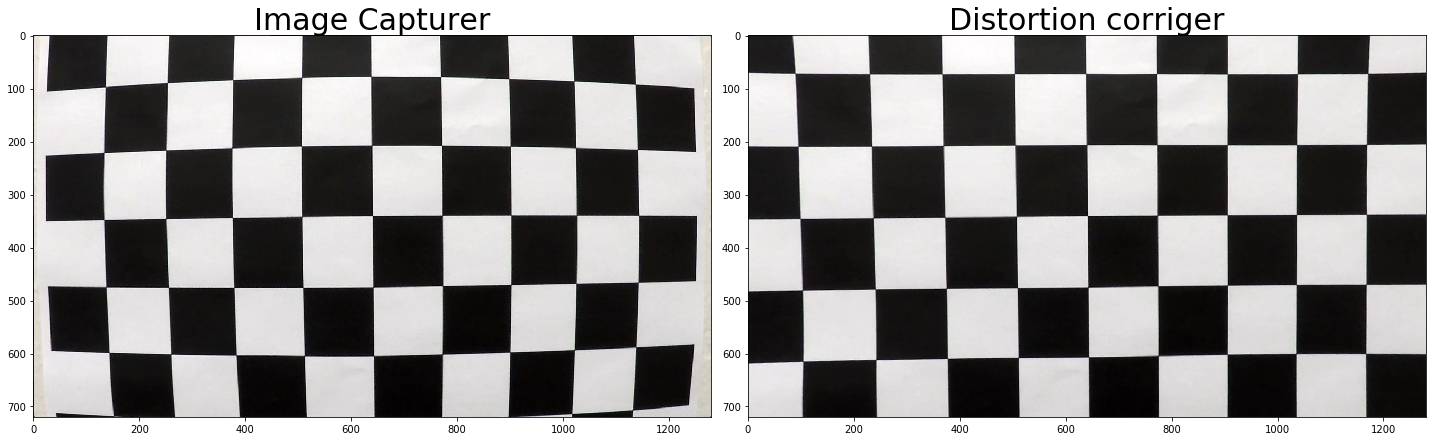

In [16]:
img = mpimg.imread('./camera_cal/calibration1.jpg')
img_size1 = (img.shape[1], img.shape[0])

undist = distort_correct(img, mtx, dist, img_size)

### Visualisation des résultats 
plt.figure()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10));
ax1.imshow(img);
ax1.set_title('Image Capturer', fontsize=30);
ax2.imshow(undist);
ax2.set_title('Distortion corriger', fontsize=30);
plt.tight_layout()
plt.savefig('saved_figures/undistorted_chess.png')

### seillage de gradient et couleur